In [11]:

##################### ARDUINOLIB STARTS HERE ###########################
from serial import Serial

class Arduino:
  """
  A wrapper class around a serial port with some helpers for easy communication to/from an Arduino.

  Example:

  ```python
  with Arduino('/dev/com.whatever', baudRate=115200) as arduino:
    for line in arduino.lines():
      print("Got line from Arduino: " + line)
      arduino.write(55) # Writes 0x55 as a byte. Also accepts raw bytes or strings.
  ```
  """

  def __init__(self, port, baudRate=115200, timeout=1, logging=False):
    """
    Connect to an Arduino
    """
    self.logging = logging
    self.serial_port = Serial(port, baudRate, timeout=timeout)

  def _log(self, *args, **kwargs):
    """
    Helper method that acts like `print`, when logging=True but does nothing otherwise.
    """
    if self.logging:
      print("[Arduino]", *args, **kwargs)
  
  # We want to just pass through to the serial port's context manager
  def __enter__(self):
    """
    When using an Arduino as a context manager, the Arduino will intelligently open/close the serial
    port upon entering/exiting the context manager, including doing so multiple times.
    """
    self._log("Entering Arduino context manager, connecting serial port...")
    self.serial_port.__enter__()

    # But return self so you can do `with Arduino(...) as arduino:`
    return self

  def __exit__(self, __exc_type, __exc_value, __traceback):
    """
    When using an Arduino as a context manager, the Arduino will intelligently open/close the serial
    port upon entering/exiting the context manager, including doing so multiple times.
    """
    self._log("Exiting Arduino context manager, disconnecting serial port...")
    return self.serial_port.__exit__(__exc_type, __exc_value, __traceback)
  
  # NB: Calling lines() or packets() more than once is undefined behavior
  def lines(self, drain_first=True):
    """
    Return an iterator that yields each line the Arduino sends over the Serial connection.

    If drain_first is True, any serial data already received and buffered but not yet processed will
    be erased.

    NOTE: This iterator will block while waiting for a line
    NOTE: Calling this method more than once, or calling it after packets() has been called, is
          undefined behavior.
    """
    if drain_first:
      self.serial_port.reset_input_buffer()

    while True:
      # NOTE: technically this would get rid of leading spaces too if that was something you cared about
      line = self.serial_port.readline().decode().strip()
      if len(line) > 0:
        self._log(f"Received Line: {line}")
        yield line

  def packets(self, drain_first=True):
    """
    Return an iterator that yields each packet the Arduino sends over the Serial connection.

    A packet is defined as a newline-terminated, comma-separated list of integers. In other words,
    this method expects that your Arduino writes data over serial that looks like this: `1,2,3\n`.

    If drain_first is True, any serial data already received and buffered but not yet processed will
    be erased.

    NOTE: This iterator will block while waiting for a line
    NOTE: Calling this method more than once, or calling it after lines() has been called, is
          undefined behavior.
    """
    for line in self.lines(drain_first=drain_first):
      packet = tuple(int(data) for data in line.split(','))
      self._log(f"Received Packet: {packet}")
      yield packet

  def write(self, data):
    """
    Write data to the Arduino over Serial. If data is bytes, it will be sent as-is. If data is an
    int, it will be converted to an unsigned 8-bit integer and sent that way (attempting to write an
    integer outside of the range 0-255 is an error). If data is a string it will be utf-8 encoded.
    If data is a list each element will be individually written as per the above rules.
    """
    self._log(f"Writing data (may need conversion to bytes): {data}")

    if not isinstance(data, bytes):
      if isinstance(data, str):
        self.write(data.encode('utf-8'))
      elif isinstance(data, int):
        self.write(data.to_bytes(1, 'big', signed=True))
      elif isinstance(data, list):
        for data_item in data:
          self.write(data_item)
      else:
        raise Exception("Cannot write data of unknown type!")
    else:
      self.serial_port.write(data)
  
  def writeln(self, data):
    """
    Write a string to the Arduino over Serial, and add a newline at the end.
    """
    return self.write(f"{data}\n")
##################### ARDUINOLIB ENDS HERE ###########################


In [12]:
from math import exp

# From MATLAB curve fit
def sensor_to_distance(sensorValue):
  """
  x = Distance, f(x) = Reading. NOTE: this is backwards of what we want
  General model Power1:
     f(x) = a*x^b
Coefficients (with 95% confidence bounds):
       a =        7709  (7265, 8153)
       b =      -1.096  (-1.113, -1.078)

Goodness of fit:
  SSE: 345.2
  R-square: 0.9982
  Adjusted R-square: 0.9981
  RMSE: 3.337
  """

  y = sensorValue
  # Nonsense formatting so it can be copy/pasted from MATLAB
  a =        7709
  b =      -1.096


  return (y / a) ** (1 / b)

In [13]:
from serial import SerialException

arduinoComPort = "/dev/cu.usbmodem143201"

def do_scan(data=[], last_xPos=0, last_yPos=0):
	data = list(data)
	try:
		with Arduino(arduinoComPort, baudRate=115200) as arduino:
			print("Connected to Arduino!")

			arduino.write([1, last_xPos, last_yPos]) # Turn on the scanner

			for status, xPos, yPos, sensorValue in arduino.packets():
				if status == 1:
					print("Done!")
					return data
				if sensorValue == 0:
					continue
				distance = sensor_to_distance(sensorValue)
				print(f"Got Packet: xPos = {xPos}, yPos = {yPos}, sensorValue = {sensorValue}, distance = {distance}in")
				data.append((xPos, yPos, distance))
				last_xPos = xPos
				last_yPos = yPos
	except SerialException:
		print("Arduino crashed! Trying to restart!")
		return do_scan(data, last_xPos, last_yPos)

In [15]:
from time import time        

data = []

for _ in range(1):
    data += do_scan()

with open(f"/Users/ariporad/work/PIE/02-miniproject2/mp2/scanner/scan_{int(time())}.csv", 'w') as f:
    for line in [('xPos', 'yPos', 'distance') ] + data:
        f.write(','.join((str(x) for x in line)) + '\n')



Connected to Arduino!
Got Packet: xPos = 90, yPos = 75, sensorValue = 53, distance = 94.03437816878682in
Got Packet: xPos = 90, yPos = 76, sensorValue = 49, distance = 101.0139503802696in
Got Packet: xPos = 90, yPos = 77, sensorValue = 53, distance = 94.03437816878682in
Got Packet: xPos = 90, yPos = 78, sensorValue = 45, distance = 109.17557434345778in
Got Packet: xPos = 90, yPos = 79, sensorValue = 53, distance = 94.03437816878682in
Got Packet: xPos = 90, yPos = 80, sensorValue = 62, distance = 81.49616759898501in
Got Packet: xPos = 90, yPos = 81, sensorValue = 67, distance = 75.92842980140074in
Got Packet: xPos = 90, yPos = 82, sensorValue = 82, distance = 63.14668280576031in
Got Packet: xPos = 90, yPos = 83, sensorValue = 194, distance = 28.781983908349268in
Got Packet: xPos = 90, yPos = 84, sensorValue = 305, distance = 19.047331040870027in
Got Packet: xPos = 90, yPos = 85, sensorValue = 325, distance = 17.9749082847011in
Got Packet: xPos = 90, yPos = 86, sensorValue = 320, distanc

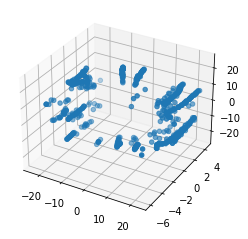

In [10]:
import matplotlib.pyplot as plt
from math import pi, sin, cos

xs = []
ys = []
zs = []

for x, y, d in ((x, (y + 90) * (pi / 180), d) for x, y, d in data if (y >= 45 and y <= 135 and d <= 25 and d >= 10)):
	xs.append(d * sin(x) * cos(y))
	ys.append(d * sin(x) * sin(y))
	zs.append(d * cos(x))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xs, ys, zs)

# ax.set_rmax(2)

# ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
# ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

# ax.set_title("A line plot on a polar axis", va='bottom')
plt.show()